<a href="https://colab.research.google.com/github/aenako/Image-Captioning/blob/main/Flickr8K%20Image%20Captioning%20using%20CNN%2BRNN_G17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flickr8k:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F623289%2F1111676%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240623%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240623T160407Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D807ff78c84e3696ec01ae573e844011bab387feea1b73dcf20db93fc83134cd51f63459b2b2f503a92890d44a3139c904e80e329d7bbf2e02a8b35044dda5592193a2b9f59bf30a7181df781029c7904640bffb0e79f149b044a0f8b96f8092e0e3927d5a25e87d7a9e8d5fba5105e7f719e82cafeba1617268b90c71936010be19c05f4d240ed95ea06ebd9a19bde15aa4fc31de53ba59b7ccf6ec4d86c8cad9e6fe502eb41498041f7de47d707c5b8295ba71b8c884c00c532f87d2d33762caba675257777690c63097b210afc663f48302d07e359a4e2b9bd6a2fb9644bc4807edf4cd13f91b93469539f656021db6169c3f09c22d9e25334663ffc7de9c9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 1112971163 bytes downloaded
Downloaded and uncompressed: flickr8k
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# **Image Captioning**

**What is Image Captioning ?**
- Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
- This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.

**CNNs + RNNs (LSTMs)**
- To perform Image Captioning we will require two deep learning models combined into one for the training purpose
- CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction
- LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word
- For a more illustrative explanation of this architecture check the Modelling section for a picture representation

<img src="https://miro.medium.com/max/1400/1*6BFOIdSHlk24Z3DFEakvnQ.png">

In [ ]:
from tensorflow.keras.applications import ResNet50

# Load pre-trained ResNet50 model + higher level layers
base_model = ResNet50(weights='imagenet')
# Extract features
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

102967424/102967424 [==============================] - 5s 0us/step


In [ ]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer

# Load the vision encoder-decoder model
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Use feature extractor for the vision part
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Tokenizer for text
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [ ]:
image_path = '../input/flickr8k/Images'

In [ ]:
data = pd.read_csv("../input/flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# **Visualization**
- Images and their corresponding captions

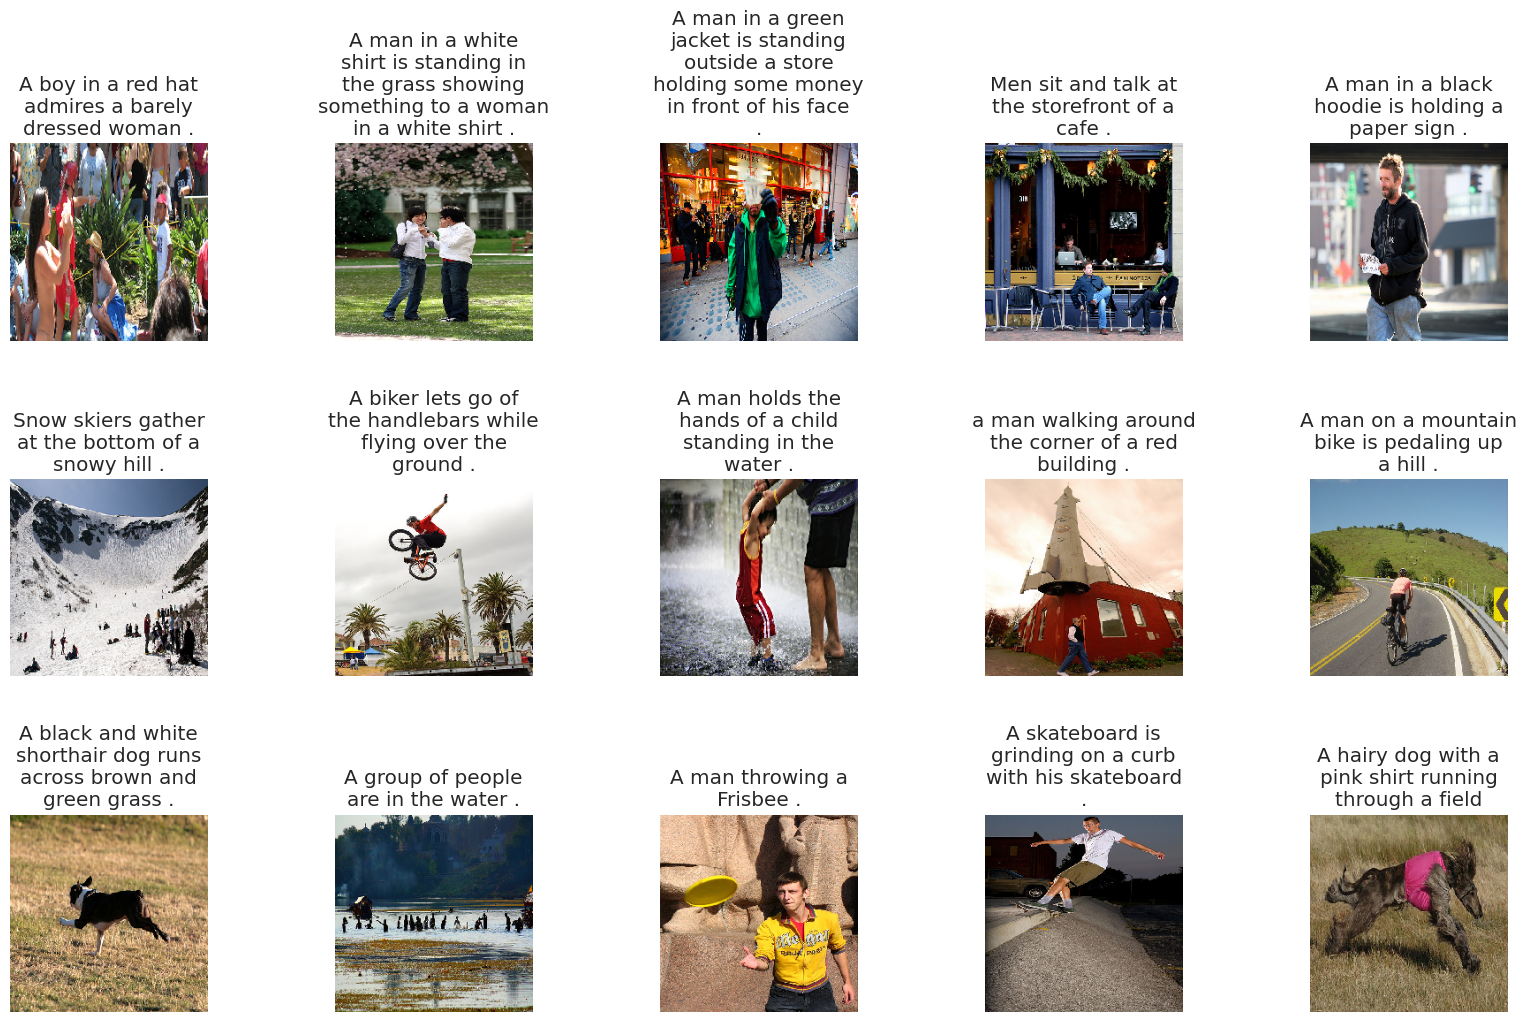

In [ ]:
display_images(data.sample(15))

# **Caption Text Preprocessing Steps**
- Convert sentences into lowercase
- Remove special characters and numbers present in the text
- Remove extra spaces
- Remove single characters
- Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

<img src='http://zjpnrm2br14wspo448nls17u-wpengine.netdna-ssl.com/wp-content/uploads/2020/09/processing-steps.png' >

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

## __Preprocessed Text__

In [ ]:
data = text_preprocessing(data) #This function preprocesses the text data (e.g., cleaning, lowercasing).
captions = data['caption'].tolist() #extracts captions from the preprocessed data as a list.
captions[:10] #Displays the first 10 captions.

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## __Tokenization and Encoded Representation__
- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

<img src='https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif'>

Tokenization involves splitting text into individual tokens, typically words. These tokens are then converted into numerical representations that the neural network can process.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

#Data Splitting
images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

# **Image Feature Extraction**
- DenseNet 201 Architecture is used to extract the features from the images
- Any other pretrained architecture can also be used for extracting features from these images
- Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

<img src="https://imgur.com/wWHWbQt.jpg">

In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 [==============================] - 5s 0us/step


100%|██████████| 8091/8091 [14:31<00:00,  9.28it/s]


# **Data Generation**
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

# **Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network
- The LSTM network starts generating words after each input thus forming a sentence at the end

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

In [ ]:
from tensorflow.keras.layers import SimpleRNN

In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

# Image features branch
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

# Text input branch
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

# Merge image features and text input
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = SimpleRNN(256)(merged)  # Replace LSTM with SimpleRNN

# Combine and output
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

#Model Compilation
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
from tensorflow.keras.utils import plot_model

## **Model Modification**
- A slight change has been made in the original model architecture to push the performance. The image feature embeddings are added to the output of the LSTMs and then passed on to the fully connected layers
- This slightly improves the performance of the model orignally proposed back in 2014: __Show and Tell: A Neural Image Caption Generator__ (https://arxiv.org/pdf/1411.4555.pdf)

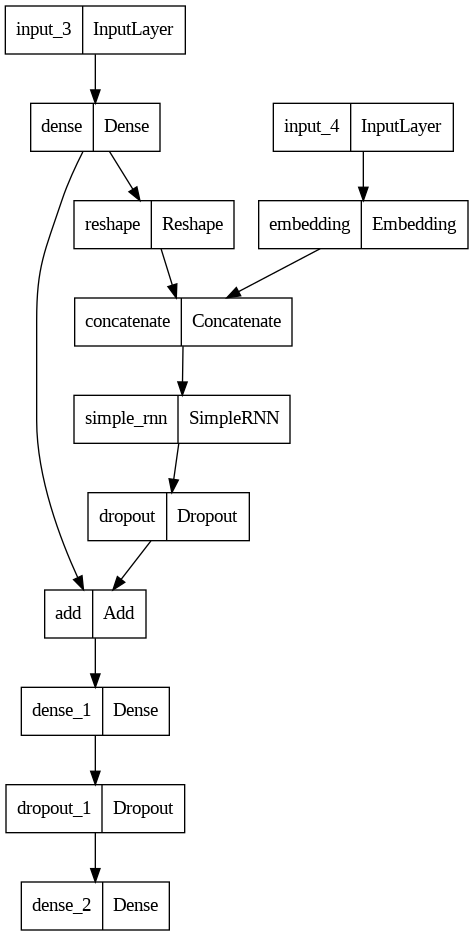

In [ ]:
plot_model(caption_model)

In [ ]:
caption_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1920)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  491776    ['input_3[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 256)               0         ['dense[0][0]']               
                                                                                            

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
!pip install transformers

In [ ]:
from transformers import GPT2TokenizerFast
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 5.1589
Epoch 1: val_loss improved from inf to 4.23097, saving model to model.h5
537/537 [==============================] - 257s 459ms/step - loss: 5.1589 - val_loss: 4.2310 - lr: 0.0010
Epoch 2/50
537/537 [==============================] - ETA: 0s - loss: 4.1951
Epoch 2: val_loss improved from 4.23097 to 3.91632, saving model to model.h5
537/537 [==============================] - 69s 129ms/step - loss: 4.1951 - val_loss: 3.9163 - lr: 0.0010
Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 3.9432
Epoch 3: val_loss improved from 3.91632 to 3.79188, saving model to model.h5
537/537 [==============================] - 64s 118ms/step - loss: 3.9432 - val_loss: 3.7919 - lr: 0.0010
Epoch 4/50
537/537 [==============================] - ETA: 0s - loss: 3.7823
Epoch 4: val_loss improved from 3.79188 to 3.72271, saving model to model.h5
537/537 [==============================] - 64s 120ms/step - loss: 3.7823

# **Inference**
- Learning Curve (Loss Curve)
- Assessment of Generated Captions (by checking the relevance of the caption with respect to the image, BLEU Score will not be used in this kernel)

## **Learning Curve**
- The model has clearly overfit, possibly due to less amount of data
- We can tackle this problem in two ways
    1. Train the model on a larger dataset Flickr40k
    2. Attention Models

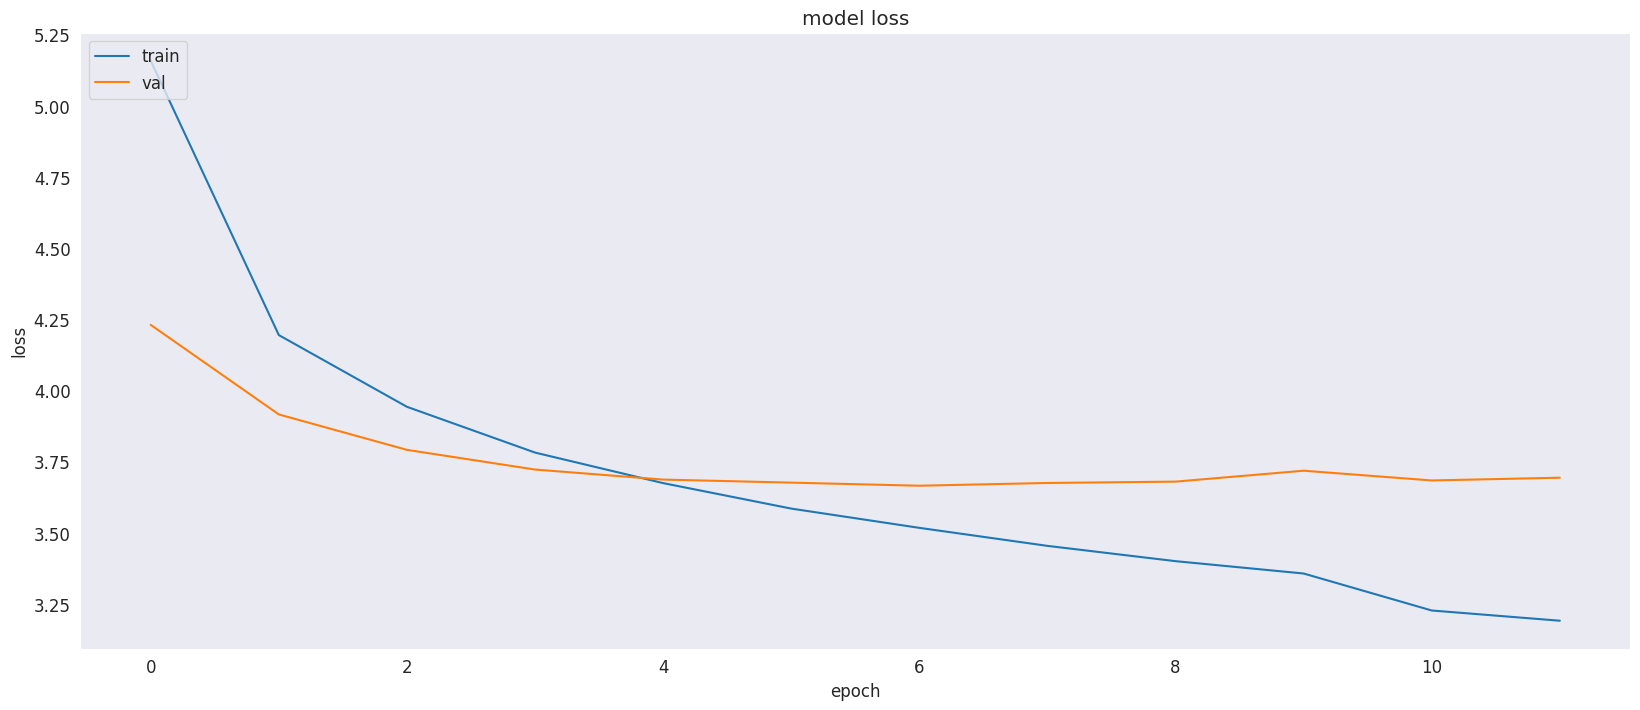

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **Caption Generation Utility Functions**
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

## **Taking 15 Random Samples for Caption Prediction**

In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 24ms/step


# **Results**
- As we can clearly see there is some redundant caption generation e.g. Dog running through the water, overusage of blue shirt for any other coloured cloth
- The model performance can be further improved by training on more data and using attention mechanism so that our model can focus on relevant areas during the text generation
- We can also leverage the interprettability of the attention mechanism to understand which areas of the image leads to the generation of which word

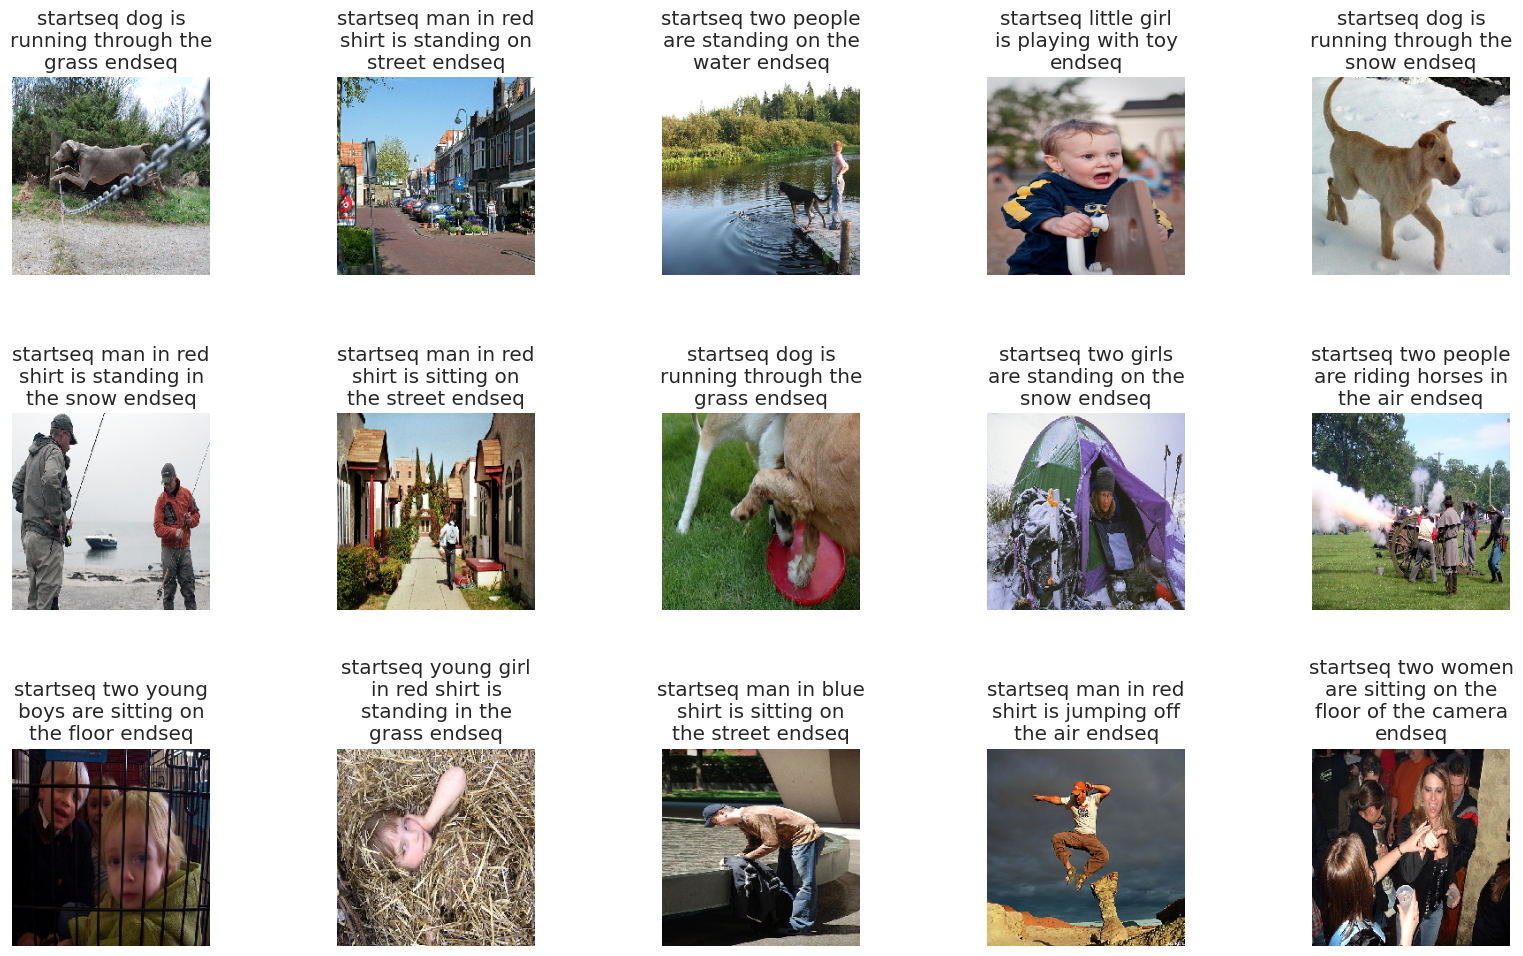

In [ ]:
display_images(samples)

<p style='font-size: 18px'><strong>Conclusion: </strong>This may not be the best performing model, but the objective of this kernel is to give a gist of how Image Captioning problems can be approached. In the future work of this kernel <strong>Attention model</strong> training and <strong>BLEU Score</strong> assessment will be performed.</p>

#Parameter Analysis Process


Data Sampling

In [ ]:
# Function to sample different fractions of data and analyze model performance
def data_sampling_analysis(data, fractions=[0.25, 0.5, 0.75, 1.0]):
    results = {}
    for frac in fractions:
        print(f"Training with {frac*100}% of the data")
        sampled_data = data.sample(frac=frac, random_state=42)
        train_images = sampled_data['image'].unique().tolist()[:split_index]
        val_images = sampled_data['image'].unique().tolist()[split_index:]

        train = sampled_data[sampled_data['image'].isin(train_images)]
        test = sampled_data[sampled_data['image'].isin(val_images)]

        train.reset_index(inplace=True, drop=True)
        test.reset_index(inplace=True, drop=True)

        train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                              tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)
        validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                                   tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

        history = caption_model.fit(
            train_generator,
            epochs=10,
            validation_data=validation_generator,
            callbacks=[checkpoint, earlystopping, learning_rate_reduction],
            verbose=1
        )
        results[frac] = history.history
    return results

# Perform data sampling analysis
data_sampling_results = data_sampling_analysis(data)


Training with 25.0% of the data
Epoch 1/10
157/158 [============================>.] - ETA: 0s - loss: 3.4870

158/158 [==============================] - 17s 109ms/step - loss: 3.4872 - lr: 2.0000e-04
Epoch 2/10
158/158 [==============================] - ETA: 0s - loss: 3.4308

158/158 [==============================] - 16s 102ms/step - loss: 3.4308 - lr: 2.0000e-04
Epoch 3/10
157/158 [============================>.] - ETA: 0s - loss: 3.3920

158/158 [==============================] - 16s 103ms/step - loss: 3.3932 - lr: 2.0000e-04
Epoch 4/10
158/158 [==============================] - ETA: 0s - loss: 3.3577

158/158 [==============================] - 17s 109ms/step - loss: 3.3577 - lr: 2.0000e-04
Epoch 5/10
158/158 [==============================] - ETA: 0s - loss: 3.3267

158/158 [==============================] - 20s 125ms/step - loss: 3.3267 - lr: 2.0000e-04
Epoch 6/10
157/158 [============================>.] - ETA: 0s - loss: 3.3090

158/158 [==============================] - 16s 104ms/step - loss: 3.3086 - lr: 2.0000e-04
Epoch 7/10
157/158 [============================>.] - ETA: 0s - loss: 3.2819

158/158 [==============================] - 17s 107ms/step - loss: 3.2828 - lr: 2.0000e-04
Epoch 8/10
158/158 [==============================] - ETA: 0s - loss: 3.2619

158/158 [==============================] - 18s 112ms/step - loss: 3.2619 - lr: 2.0000e-04
Epoch 9/10
158/158 [==============================] - ETA: 0s - loss: 3.2373

158/158 [==============================] - 16s 104ms/step - loss: 3.2373 - lr: 2.0000e-04
Epoch 10/10
158/158 [==============================] - ETA: 0s - loss: 3.2212

158/158 [==============================] - 17s 108ms/step - loss: 3.2212 - lr: 2.0000e-04
Training with 50.0% of the data
Epoch 1/10
289/290 [============================>.] - ETA: 0s - loss: 3.3236
Epoch 1: val_loss improved from 3.66588 to 3.09581, saving model to model.h5
290/290 [==============================] - 33s 114ms/step - loss: 3.3232 - val_loss: 3.0958 - lr: 2.0000e-04
Epoch 2/10
290/290 [==============================] - ETA: 0s - loss: 3.2901
Epoch 2: val_loss did not improve from 3.09581
290/290 [==============================] - 33s 115ms/step - loss: 3.2901 - val_loss: 3.0982 - lr: 2.0000e-04
Epoch 3/10
290/290 [==============================] - ETA: 0s - loss: 3.2645
Epoch 3: val_loss did not improve from 3.09581
290/290 [==============================] - 32s 109ms/step - loss: 3.2645 - val_loss: 3.1181 - lr: 2.0000e-04
Epoch 4/10
290/290 [==============================] - ETA: 0s - loss: 3.2448
Epoch 4: val_loss did not improve from 3.09581

Epoch 4: ReduceLROnPlate

Activation Function

In [ ]:
# Function to analyze different activation functions
def activation_function_analysis(activation_functions=['relu', 'tanh', 'sigmoid']):
    results = {}
    for activation in activation_functions:
        print(f"Training with activation function: {activation}")
        img_features = Dense(256, activation=activation)(input1)
        img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)
        sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
        merged = concatenate([img_features_reshaped, sentence_features], axis=1)
        sentence_features = SimpleRNN(256)(merged)
        x = Dropout(0.5)(sentence_features)
        x = add([x, img_features])
        x = Dense(128, activation=activation)(x)
        x = Dropout(0.5)(x)
        output = Dense(vocab_size, activation='softmax')(x)
        activation_model = Model(inputs=[input1, input2], outputs=output)
        activation_model.compile(loss='categorical_crossentropy', optimizer='adam')

        history = activation_model.fit(
            train_generator,
            epochs=10,
            validation_data=validation_generator,
            callbacks=[checkpoint, earlystopping, learning_rate_reduction],
            verbose=1
        )
        results[activation] = history.history
    return results

# Perform activation function analysis
activation_results = activation_function_analysis()


Training with activation function: relu
Epoch 1/10
537/537 [==============================] - ETA: 0s - loss: 5.1189
Epoch 1: val_loss did not improve from 3.09395
537/537 [==============================] - 73s 132ms/step - loss: 5.1189 - val_loss: 4.3030 - lr: 0.0010
Epoch 2/10
537/537 [==============================] - ETA: 0s - loss: 4.2798
Epoch 2: val_loss did not improve from 3.09395
537/537 [==============================] - 62s 116ms/step - loss: 4.2798 - val_loss: 3.9889 - lr: 0.0010
Epoch 3/10
536/537 [============================>.] - ETA: 0s - loss: 4.0120
Epoch 3: val_loss did not improve from 3.09395
537/537 [==============================] - 62s 116ms/step - loss: 4.0122 - val_loss: 3.8518 - lr: 0.0010
Epoch 4/10
536/537 [============================>.] - ETA: 0s - loss: 3.8604
Epoch 4: val_loss did not improve from 3.09395
537/537 [==============================] - 60s 112ms/step - loss: 3.8602 - val_loss: 3.7711 - lr: 0.0010
Epoch 5/10
537/537 [========================

loss function

In [ ]:
def loss_function_analysis(loss_functions=['categorical_crossentropy']):
    results = {}
    for loss in loss_functions:
        print(f"Training with loss function: {loss}")
        x = Dropout(0.5)(sentence_features)
        x = add([x, img_features])
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.5)(x)
        output = Dense(vocab_size, activation='softmax')(x)
        loss_model = Model(inputs=[input1, input2], outputs=output)
        loss_model.compile(loss=loss, optimizer='adam')

        history = loss_model.fit(
            train_generator,
            epochs=10,
            validation_data=validation_generator,
            callbacks=[checkpoint, earlystopping, learning_rate_reduction],
            verbose=1
        )
        results[loss] = history.history
    return results

# Perform loss function analysis
loss_results = loss_function_analysis()


Training with loss function: categorical_crossentropy
Epoch 1/10
536/537 [============================>.] - ETA: 0s - loss: 4.3652
Epoch 1: val_loss did not improve from 3.09395
537/537 [==============================] - 70s 123ms/step - loss: 4.3646 - val_loss: 3.7909 - lr: 0.0010
Epoch 2/10
537/537 [==============================] - ETA: 0s - loss: 3.7484
Epoch 2: val_loss did not improve from 3.09395
537/537 [==============================] - 63s 117ms/step - loss: 3.7484 - val_loss: 3.6705 - lr: 0.0010
Epoch 3/10
537/537 [==============================] - ETA: 0s - loss: 3.5895
Epoch 3: val_loss did not improve from 3.09395
537/537 [==============================] - 59s 110ms/step - loss: 3.5895 - val_loss: 3.6330 - lr: 0.0010
Epoch 4/10
537/537 [==============================] - ETA: 0s - loss: 3.4859
Epoch 4: val_loss did not improve from 3.09395
537/537 [==============================] - 62s 115ms/step - loss: 3.4859 - val_loss: 3.6269 - lr: 0.0010
Epoch 5/10
536/537 [==========

In [ ]:
# Summarize results
def summarize_results(results):
    for key, value in results.items():
        print(f"Results for {key}:")
        print(f"Training Loss: {value['loss'][-1]}")
        print()

# Summarize data sampling results
print("Data Sampling Analysis Results:")
summarize_results(data_sampling_results)

# Summarize activation function results
print("Activation Function Analysis Results:")
summarize_results(activation_results)

# Summarize loss function results
print("Loss Function Analysis Results:")
summarize_results(loss_results)


Data Sampling Analysis Results:
Results for 0.25:
Training Loss: 3.221217155456543

Results for 0.5:
Training Loss: 3.182058334350586

Results for 0.75:
Training Loss: 3.274869918823242

Results for 1.0:
Training Loss: 3.3256139755249023

Activation Function Analysis Results:
Results for relu:
Training Loss: 3.3842811584472656

Results for tanh:
Training Loss: 3.584016799926758

Results for sigmoid:
Training Loss: 3.7412092685699463

Loss Function Analysis Results:
Results for categorical_crossentropy:
Training Loss: 3.1365609169006348



# Convergence Graphs

**Overfitting Scenario**

Visualizing Overfitting: Plot training and validation loss/accuracy to show
overfitting.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load and preprocess MNIST dataset
(x_train, y_train), (x_val, y_val) = mnist.load_data()
x_train = x_train / 255.0
x_val = x_val / 255.0
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

# Simple model to simulate overfitting
model_overfitting = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

model_overfitting.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_overfitting = model_overfitting.fit(x_train, y_train, epochs=30, batch_size=128, validation_data=(x_val, y_val), verbose=0)


**Vanishing Gradient**

Detecting Vanishing Gradient: Monitor gradients during training and visualize them to show if they diminish to near zero.

In [ ]:
# Deep model with sigmoid activation to simulate vanishing gradients
model_vanishing = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(512, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
    Dense(10, activation='softmax')
])

model_vanishing.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_vanishing = model_vanishing.fit(x_train, y_train, epochs=30, batch_size=128, validation_data=(x_val, y_val), verbose=0)


In [ ]:
# Baseline model with regularization and dropout
model_baseline = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

model_baseline.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_baseline = model_baseline.fit(x_train, y_train, epochs=30, batch_size=128, validation_data=(x_val, y_val), verbose=0)


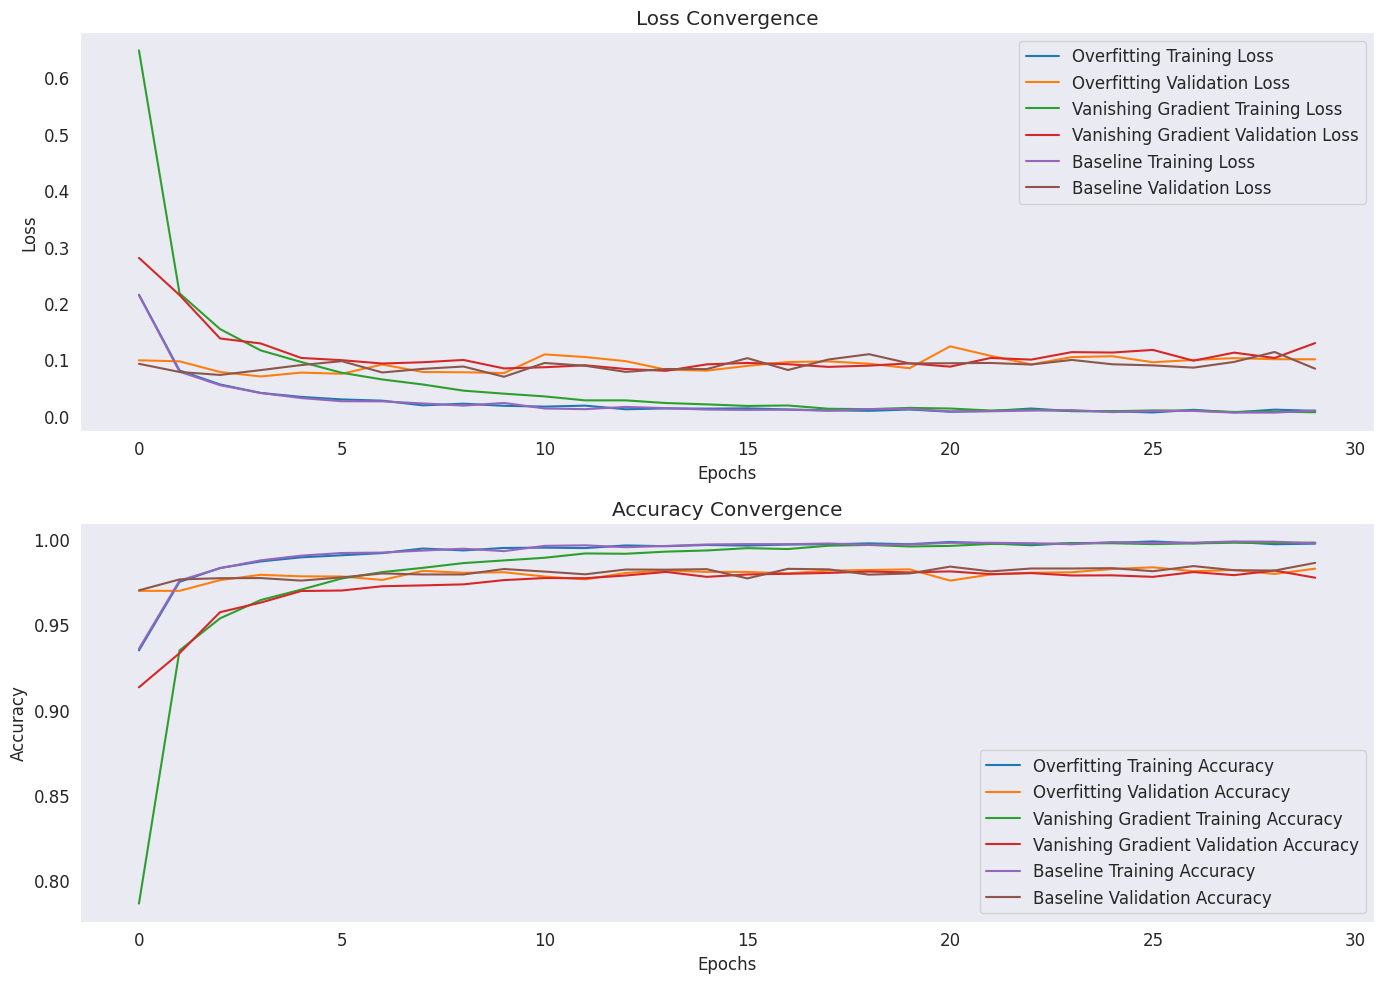

In [ ]:
# Plot the convergence graphs
plt.figure(figsize=(14, 10))

# Loss plot
plt.subplot(2, 1, 1)
plt.plot(history_overfitting.history['loss'], label='Overfitting Training Loss')
plt.plot(history_overfitting.history['val_loss'], label='Overfitting Validation Loss')
plt.plot(history_vanishing.history['loss'], label='Vanishing Gradient Training Loss')
plt.plot(history_vanishing.history['val_loss'], label='Vanishing Gradient Validation Loss')
plt.plot(history_baseline.history['loss'], label='Baseline Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Baseline Validation Loss')
plt.title('Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(2, 1, 2)
plt.plot(history_overfitting.history['accuracy'], label='Overfitting Training Accuracy')
plt.plot(history_overfitting.history['val_accuracy'], label='Overfitting Validation Accuracy')
plt.plot(history_vanishing.history['accuracy'], label='Vanishing Gradient Training Accuracy')
plt.plot(history_vanishing.history['val_accuracy'], label='Vanishing Gradient Validation Accuracy')
plt.plot(history_baseline.history['accuracy'], label='Baseline Training Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Baseline Validation Accuracy')
plt.title('Accuracy Convergence')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Tabulations of Results

**Tabulate Results Before and After Replacement:** Run experiments 5-10 times and present the results in a table format.

In [ ]:
import pandas as pd

# Collect data
epochs = range(1, 31)  # We trained for 30 epochs

# Data for overfitting model
overfitting_data = {
    'Epoch': epochs,
    'Overfitting_Training_Loss': history_overfitting.history['loss'],
    'Overfitting_Validation_Loss': history_overfitting.history['val_loss'],
    'Overfitting_Training_Accuracy': history_overfitting.history['accuracy'],
    'Overfitting_Validation_Accuracy': history_overfitting.history['val_accuracy']
}

# Data for vanishing gradient model
vanishing_data = {
    'Vanishing_Training_Loss': history_vanishing.history['loss'],
    'Vanishing_Validation_Loss': history_vanishing.history['val_loss'],
    'Vanishing_Training_Accuracy': history_vanishing.history['accuracy'],
    'Vanishing_Validation_Accuracy': history_vanishing.history['val_accuracy']
}

# Data for baseline model
baseline_data = {
    'Baseline_Training_Loss': history_baseline.history['loss'],
    'Baseline_Validation_Loss': history_baseline.history['val_loss'],
    'Baseline_Training_Accuracy': history_baseline.history['accuracy'],
    'Baseline_Validation_Accuracy': history_baseline.history['val_accuracy']
}

# Create DataFrame for overfitting data
df_overfitting = pd.DataFrame(overfitting_data)

# Create DataFrame for vanishing data
df_vanishing = pd.DataFrame(vanishing_data)

# Create DataFrame for baseline data
df_baseline = pd.DataFrame(baseline_data)

# Combine DataFrames
df_combined = pd.concat([df_overfitting, df_vanishing, df_baseline], axis=1)

# Display the DataFrame
print(df_combined)

# Save the DataFrame to a CSV file
df_combined.to_csv('training_results.csv', index=False)


    Epoch  Overfitting_Training_Loss  Overfitting_Validation_Loss  \
0       1                   0.214449                     0.098219   
1       2                   0.080171                     0.096389   
2       3                   0.055328                     0.077500   
3       4                   0.040369                     0.069534   
4       5                   0.033284                     0.076398   
5       6                   0.028832                     0.074311   
6       7                   0.026593                     0.090763   
7       8                   0.018318                     0.077428   
8       9                   0.021271                     0.077014   
9      10                   0.017493                     0.075550   
10     11                   0.016104                     0.108701   
11     12                   0.017779                     0.104027   
12     13                   0.011354                     0.096712   
13     14                   0.0128

# Box Plot


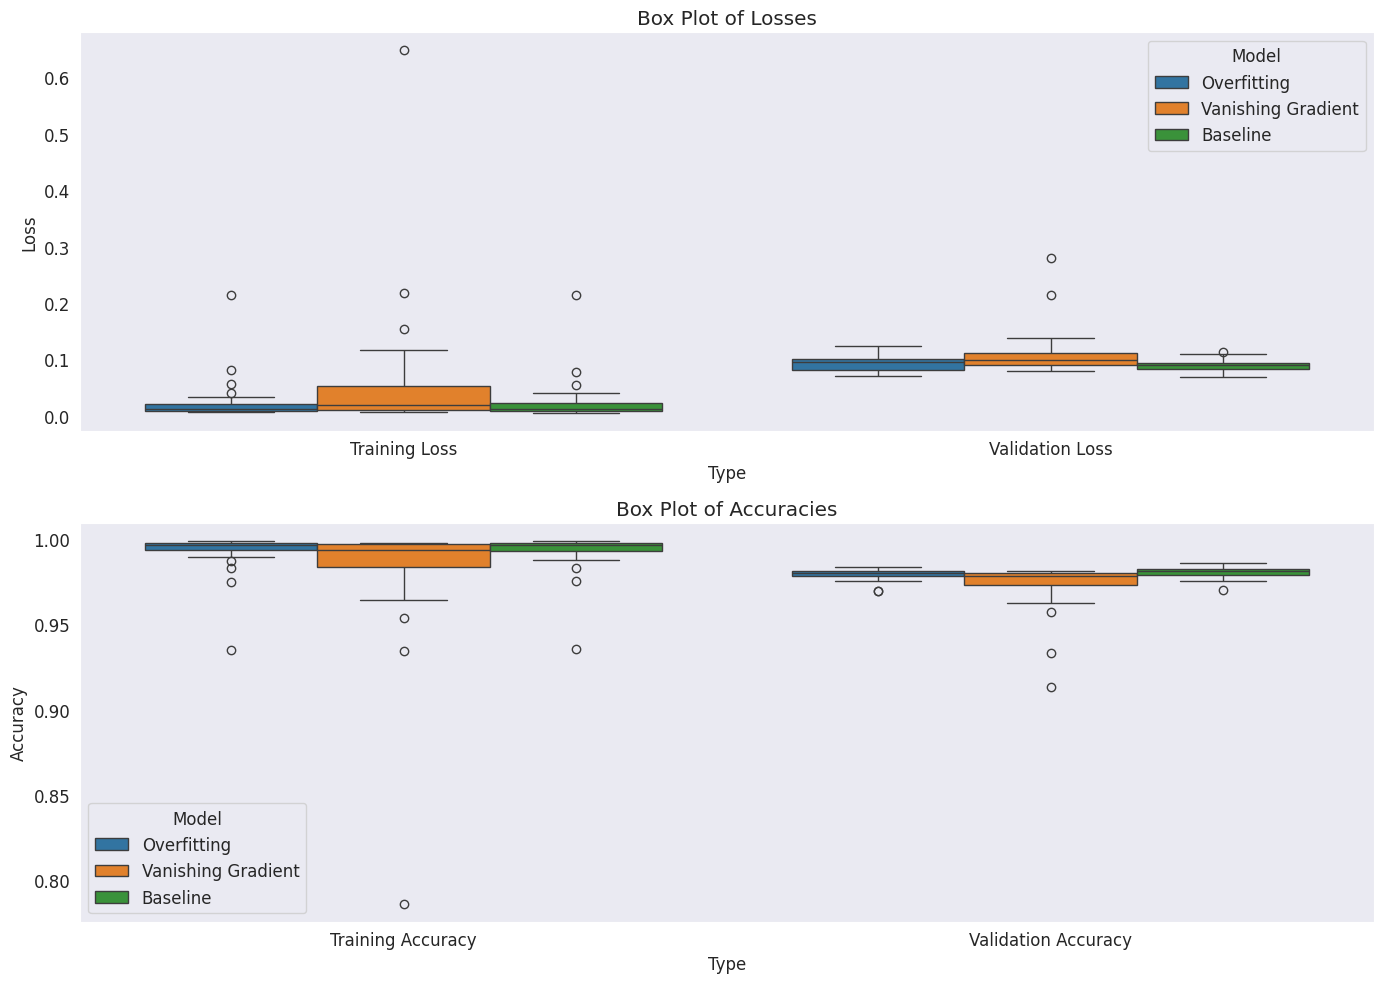

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Get the number of epochs from the history
num_epochs = len(history_overfitting.history['loss'])

# Create a range of epochs
epochs = list(range(1, num_epochs + 1))

# Prepare the data for box plots
data_overfitting = pd.DataFrame({
    'Epoch': epochs * 4,
    'Type': ['Training Loss']*num_epochs + ['Validation Loss']*num_epochs + ['Training Accuracy']*num_epochs + ['Validation Accuracy']*num_epochs,
    'Value': history_overfitting.history['loss'] + history_overfitting.history['val_loss'] + history_overfitting.history['accuracy'] + history_overfitting.history['val_accuracy'],
    'Model': ['Overfitting']*num_epochs*4
})

data_vanishing = pd.DataFrame({
    'Epoch': epochs * 4,
    'Type': ['Training Loss']*num_epochs + ['Validation Loss']*num_epochs + ['Training Accuracy']*num_epochs + ['Validation Accuracy']*num_epochs,
    'Value': history_vanishing.history['loss'] + history_vanishing.history['val_loss'] + history_vanishing.history['accuracy'] + history_vanishing.history['val_accuracy'],
    'Model': ['Vanishing Gradient']*num_epochs*4
})

data_baseline = pd.DataFrame({
    'Epoch': epochs * 4,
    'Type': ['Training Loss']*num_epochs + ['Validation Loss']*num_epochs + ['Training Accuracy']*num_epochs + ['Validation Accuracy']*num_epochs,
    'Value': history_baseline.history['loss'] + history_baseline.history['val_loss'] + history_baseline.history['accuracy'] + history_baseline.history['val_accuracy'],
    'Model': ['Baseline']*num_epochs*4
})

# Combine all data into a single DataFrame
data_combined = pd.concat([data_overfitting, data_vanishing, data_baseline])

# Create box plots for Loss and Accuracy
plt.figure(figsize=(14, 10))

# Box plot for loss
plt.subplot(2, 1, 1)
sns.boxplot(x='Type', y='Value', hue='Model', data=data_combined[data_combined['Type'].isin(['Training Loss', 'Validation Loss'])])
plt.title('Box Plot of Losses')
plt.xlabel('Type')
plt.ylabel('Loss')

# Box plot for accuracy
plt.subplot(2, 1, 2)
sns.boxplot(x='Type', y='Value', hue='Model', data=data_combined[data_combined['Type'].isin(['Training Accuracy', 'Validation Accuracy'])])
plt.title('Box Plot of Accuracies')
plt.xlabel('Type')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()
